In [1]:
import pandas as pd
import numpy as np
import numpy.linalg as LA
import math
import matplotlib.pyplot as plt
import networkx as nx
import sklearn
from sklearn import manifold, datasets
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
import bisect

def decide_case(z,L,d,G,epsilon):
    if G.degree[z] == 0:
        return 3
    else:
        for l in L:
            if d(l,z) < epsilon:
                return 1
                break
        return 2
        
def adjacency_list(G):
    nodes_graph = list(G.nodes())
    edges_graph = list(G.edges)
    adj_list = {x:[] for x in nodes_graph}
    
    for key in list(adj_list.keys()):
        for node1,node2 in edges_graph:
            if key == node1:
                adj_list[key].append(node2)
            if key == node2:
                adj_list[key].append(node1)
                
    return adj_list

def update_graph_and_adjacency(G,Adj,x,y):#Use the adjacency list Adj to update the graph G.
    if x not in list(G.nodes()):
        G.add_node(x)
        
    if y not in list(G.nodes()):
        G.add_node(y)
        
    G.add_edge(x,y)
    
    if x not in list(Adj.keys()) and y not in list(Adj.keys()):
        Adj[x] = [y]
        Adj[y] = [x]
        
    elif x not in list(Adj.keys()) and y in list(Adj.keys()):
        Adj[x] = [y]
        Adj[y].append(x)
        
    elif x in list(Adj.keys()) and y not in list(Adj.keys()):
        Adj[x].append(y)
        Adj[y] = [x]
        
    else:
        Adj[x].append(y)
        Adj[y].append(x)
        
    return Adj

def OnlyBy(Adj,z,L,n):#Adj=adjacency list,z=the landmark in which we compute,L=set of landmarks,n=number of nodes
    if z not in L:
        return("Not a landmark")
    
    if set(Adj[z]).issubset(L):
        return set()
    else:
        union_neighbor = []
        
        for l in L:
            if l!=z:
                union_neighbor = union_neighbor + Adj[l]
            else:
                continue
        
        compare_union = [0]*n
        compare_z = [0]*n
        
        for i in union_neighbor:
            compare_union[i] = 1
            
        for i in Adj[z]:
            compare_z[i] = 1
            
        result = set()
        for i,j in enumerate(compare_z):
            if j == 1:
                if compare_union[i] == 0:
                    result.add(i)
                else:
                    continue
            else:
                continue
        
        return result

def REMOVE(x,y,Adj,L,n):
    if x in L and y in L:
        if OnlyBy(Adj,x,L,n) == set():
            return {x}
        elif OnlyBy(Adj,y,L,n) == set():
            return {y}
        else:
            return set()
    elif x in L and y not in L:
        if OnlyBy(Adj,x,L,n) == set():
            return {x}
        else:
            return set()
    else:
        if OnlyBy(Adj,y,L,n) == set():
            return {y}
        else:
            return set()

def Merge_sort(A,B):
    A1 = [x[1] for x in A]
    B1 = [x[1] for x in B]
    i = 0
    j = 0
    C = []
    while i < len(A1) and j < len(B1):
        if A1[i] <= B1[j]:
            C.append(A[i])
            i = i + 1
        else:
            C.append(B[j])
            j = j + 1
    if i == len(A1):
        return C + B[j:]
    elif j == len(B1):
        return C + A[i:]
    else:
        print("Error")

def landmark_replacement(G,Adj,L,x,dist,dist_new,epsilon):#G=graph, L=landmarks,x=new datum,d=distance function
    V = list(G.nodes())
    n = len(V)#do not forget to update n

    if G.degree[x] <= 2*np.sqrt(len(G.edges())):
        L.add(x)
    else:
        for i in G.neighbors(x):
            if G.degree[i] <= np.sqrt(len(G.edges())):
                L.add(i)
                break
            else:
                continue

    dist_all = Merge_sort(dist,dist_new)
    pw_dist = [x[1] for x in dist_all]
    pw_node = [x[0] for x in dist_all]
    ell, k = pw_node[0]
    epsilon = pw_dist[0]
    count = 0
    
    while (ell not in L) and (k not in L):
        count = count +1
        ell,k = pw_node[count]
        epsilon = pw_dist[count]
        Adj = update_graph_and_adjacency(G,Adj,ell,k)
        n = len(Adj.keys())
        
    pi = REMOVE(ell,k,Adj,L,n)
    
    while pi == set():
        count = count + 1
        epsilon = pw_dist[count]
        v1,v2 = pw_node[count]#To update the edges
        Adj = update_graph_and_adjacency(G,Adj,v1,v2)
        n = len(Adj.keys())
        pi = REMOVE(ell,k,Adj,L,n)

    L = L-pi
    return L, epsilon, Adj, dist_all

def d2(x,y):#Euclidean distance between two nodes, where pos[x],pos[y] are the coordinate of x and y, respectively.
    return np.linalg.norm(np.array(pos[x])-np.array(pos[y]))

In [2]:
X0, y0 = sklearn.datasets.make_s_curve(n_samples=1000,noise=0, random_state=1)#To import S-curve from sklearn.
zipped = zip(X0,y0)
zipped = list(zipped)
res = sorted(zipped, key = lambda x: x[1])#Sort the data points by the univariate position.
X = [i for i,j in res]
X = np.array(X)
y = [j for i,j in res]
y = np.array(y)

In [3]:
G = nx.Graph()
m = 100#the permitted number of landmarks
epsilon = 10**-20
G.add_nodes_from([(i,{"pos":(X[i,0],X[i,1],X[i,2])}) for i in range(0,m)])#Assign the coordinate for each node.
pos=nx.get_node_attributes(G,'pos')
for i in G.nodes:
    for j in G.nodes:
        if i != j and d2(i,j) < epsilon:
            G.add_edge(i,j)
#adj_list = adjacency_list(G)

In [4]:
pairwise_dist = []
for i in G.nodes:#Compute the pairwise distance of any pair of existing nodes in G.
    for j in G.nodes:
        if i < j:
            pairwise_dist.append([(i,j),d2(i,j)])
pairwise_dist.sort(key = lambda x:x[1])#Sort the elements in pairwise_dist by the encoded distance values.

In [5]:
L = set(range(0,m))#Initialized landmarks
epsilon_growth = [10**-20]#To keep track the epsilon-value once the new data have been admitted.

In [6]:
%%time
adj_list = adjacency_list(G)
index0 = bisect.bisect_left([x[1] for x in pairwise_dist], epsilon)
dist = pairwise_dist[index0:]
for ai in range(m,1000):
    G.add_nodes_from([(i,{"pos":(X[i,0],X[i,1],X[i,2])}) for i in range(ai,ai+1)])
    pos=nx.get_node_attributes(G,'pos')
    adj_list[ai] = []
    dist_new = []

    for i in G.nodes:
        if i != ai and d2(i,ai) < epsilon:
            adj_list = update_graph_and_adjacency(G,adj_list,i,ai)
        elif i != ai and d2(i,ai) >= epsilon:
            dist_new.append([(i,ai),d2(i,ai)])
        else:
            continue
    dist_new.sort(key = lambda x: x[1])
    
    if decide_case(ai,L,d2,G,epsilon) == 1:
        epsilon_growth.append([epsilon,ai])
        continue
    
    elif len(L) < m:
        L.add(ai)
        epsilon_growth.append([epsilon,ai])
        continue
    else:
        Z = landmark_replacement(G,adj_list,L,ai,dist,dist_new,epsilon)
        L = Z[0]
        epsilon1 = Z[1]
        epsilon_growth.append([epsilon1,ai])
        epsilon = epsilon1
        adj_list = Z[2]
        dist_old = Z[3]
        index = bisect.bisect_left([x[1] for x in dist_old], epsilon)
        dist = dist_old[index:]

CPU times: user 14.2 s, sys: 15.5 ms, total: 14.3 s
Wall time: 14.3 s


In [7]:
from LandmarkMDS import *

In [8]:
sq_distance_mat = np.zeros((len(L),len(L)))#the distance matrix
for i, ti in enumerate(L):
    for j, tj in enumerate(L):
        if i == j:
            sq_distance_mat[i][j] = 0
            sq_distance_mat[j][i] = 0
        elif i < j:
            sq_distance_mat[i][j] = d2(ti,tj)**2
            sq_distance_mat[j][i] = sq_distance_mat[i][j]
        else:
            continue
Landmark_eigenpair = Classical_MDS(sq_distance_mat,2)[1]#Eigenpairs already dependend on the choice of distance.
delta_mu = Col_sum(sq_distance_mat)

N = np.shape(sq_distance_mat)[1]
inv_sqrt_eigenvalues = []
L_prime_before = []
k = 2#Embedding dimension
for i in range(0,k):
    if Landmark_eigenpair[i][0] > 0:
        inv_sqrt_eigenvalues.append(1 / np.sqrt(Landmark_eigenpair[i][0]))
    
for i in range(0,k):
    vi = inv_sqrt_eigenvalues[i] * Landmark_eigenpair[i][1]
    L_prime_before = np.concatenate((L_prime_before,vi.tolist()), axis = 0)
        
L_prime = np.reshape(L_prime_before, (k,N))

embed_coord = []
for i in G.nodes():
    delta = vector_sq_dist(i,L,d2)
    delta = delta.reshape((len(L),1))
    Del = delta - delta_mu
    embed_coord.append(-0.5 * np.matmul(L_prime,Del))

X_embed = [embed_coord[i][0][0].real for i in G.nodes()]#x-axis embedding coordinate
Y_embed = [embed_coord[i][1][0].real for i in G.nodes()]#y-axis embedding coordinate

L_embed_x = [embed_coord[i][0][0].real for i in L]#x-axis landmark embedding coordinate
L_embed_y = [embed_coord[i][1][0].real for i in L]#y-axis landmark embedding coordinate

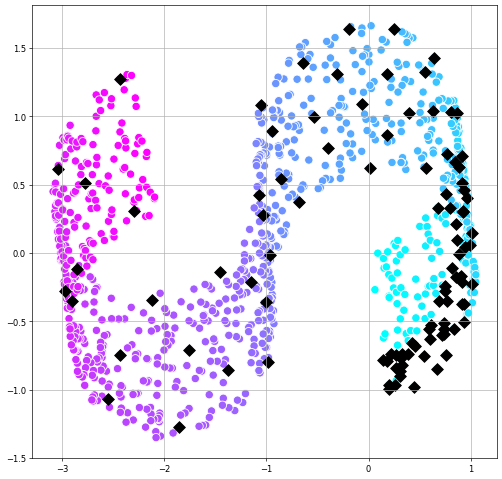

In [9]:
w = 10
h = 10
d = 60
plt.figure(figsize=(w, h), dpi=d)
plt.scatter(X_embed, Y_embed, s=100, ec="w",c=y,cmap=plt.cm.cool)
plt.scatter(L_embed_x, L_embed_y,s=100,color = 'black',zorder = 1, marker = "D")
plt.grid()
plt.show()